In [1]:
# hide
# default_exp blocks.preprocessing
from nbdev.showdoc import *
from block_types.utils.nbdev_utils import nbdev_setup, TestRunner

nbdev_setup ()
tst = TestRunner (targets=['dummy'])

# Preprocessing components

> Preprocessing components like one hot encoder

In [2]:
#export
import numpy as np
import pandas as pd
import sklearn.preprocessing
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError

try:
    from tensorflow.keras.preprocessing import timeseries_dataset_from_array
    keras_not_imported = False
except:
    keras_not_imported = True

from block_types.core.block_types import PandasComponent, SamplingComponent
from block_types.config import bt_defaults as dflt

2022-01-17 17:28:16.909920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2022-01-17 17:28:16.909963: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#for tests
import pytest 

## OneHotEncoder

In [4]:
#export
class OneHotEncoder (PandasComponent):
    def __init__ (self, 
                  categories='auto',
                  handle_unknown='ignore',
                  dtype=int,
                  **kwargs):
        super().__init__ (**kwargs)
        self.categories = categories
        self.handle_unknown = handle_unknown
        self.one_hot_encoder = sklearn.preprocessing.OneHotEncoder(categories=categories,
                                                                    handle_unknown=handle_unknown,
                                                                    sparse=False)
        self.dtype = dtype
        
    def _fit (self, X, y=None):
        self.one_hot_encoder.fit (X)
        return self
    
    def _apply (self, df):
        try:
            check_is_fitted (self.one_hot_encoder)
        except NotFittedError:
            if self.categories != 'auto':
                self.one_hot_encoder.fit(df)
            else:
                raise NotFittedError('OneHotEncoder must be fitted first')
        X = self.one_hot_encoder.transform(df)
        if self.dtype is int or self.dtype == 'int':
            X = X.astype(int)
        df = pd.DataFrame (data=X, 
                           columns=self.one_hot_encoder.get_feature_names(input_features=df.columns),
                           index=df.index)
        return df

### Example / test

In [5]:
# exports tests.blocks.test_preprocessing
#@pytest.mark.reference_fails
def test_one_hot_encoder ():
    df = pd.DataFrame({'x1':['b','b','a','b','a'],
                   'x2':['e','c','d','e','f'],
                  })
    one_hot_encoder = OneHotEncoder(categories=[['a','b'],['c','d','e']])
    dfr = one_hot_encoder.transform (df)

    # show result
    print ('result:')
    display (dfr)

    # compare against pd.get_dummies, removing last column corresponding to category 'f'
    df_dummies = pd.get_dummies (df).iloc[:,:-1] 
    assert (dfr==df_dummies).all().all()

    # test categories='auto'
    one_hot_encoder = OneHotEncoder(categories='auto')

    # 1.- if categories='auto', we must call fit  before calling transform:
    with pytest.raises(Exception):
        dfr = one_hot_encoder.transform (df)

    # test that 'auto' returns the same as pd.get_dummies
    dfr = one_hot_encoder.fit_transform (df)
    print ('result:'); display(dfr)
    assert (dfr==pd.get_dummies (df)).all().all()

In [6]:
tst.run (test_one_hot_encoder, tag='dummy')

running test_one_hot_encoder
result:


,x1_a,x1_b,x2_c,x2_d,x2_e
0,0,1,0,0,1
1,0,1,1,0,0
2,1,0,0,1,0
3,0,1,0,0,1
4,1,0,0,0,0


result:


,x1_a,x1_b,x2_c,x2_d,x2_e,x2_f
0,0,1,0,0,1,0
1,0,1,1,0,0,0
2,1,0,0,1,0,0
3,0,1,0,0,1,0
4,1,0,0,0,0,1


## WindowGenerator

Windows transformer for time-series that allows to easily select time windows that contain desired metadata. Currently, the implementation is especially conceived for anomaly detection, selecting windows that are "normal data" and that do not contain any nan. It also allows to easily plot any time window of interest, select a subset of variables, and do many other types of analysis based on the well-known DataFrame API.

In [7]:
# export
class WindowGenerator (SamplingComponent):
    """
    Creates a DataFrame of time-ordered sliding windows extracted from an input time-series.
    
    The input time-series is given as a DataFrame with N rows and D+1 columns, where N is 
    the number of observations (i.e., number of time-steps) and D is the number of variables
    and there is an additional column for the ground-truth label. 
    
    The output DataFrame has one row per sliding window, and W*D+1 columns, where W is 
    the size of the sliding windows (or sequence length).
    
    While not implemented at this moment, the WindowGenerator can use, in addition to 
    label information, other types of metadata attributes such as chiller ID. All this metadata
    is handled the same way as we do with the label. In case of large missing gaps, the 
    DataFrame can implicitly be split into sections, where each section is contiguous 
    (i.e., without gaps). In this case, an additional column indicates the index of the section,
    from 0 to S-1. This column is then treated as the other two metadata attributes (label 
    and chiller ID), making sure that sliding windows have only one value for each one of 
    these attributes (i.e, contains only normal or anomaly data but not both, contains data 
    from only one chiller, and contains data from only one section). See documentation for an 
    illustration.
    """
    def __init__ (self,
                  sequence_length=None,
                  sequence_stride=None,
                  mixed_labels=False,
                  sampling_interval=None,
                  **kwargs):
        """
        Initialize fields.
        
        Parameters
        ----------
        sequence_length : int, optional
            Size of each window, in number of timesteps.
        sequence_stride : int, optional
            Period between successive output sequences. 
            For stride s, output samples would start at index 
            data[i], data[i + s], data[i + 2 * s], etc.:
            https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array
        mixed_labels : bool, optional
            Whether the same window can contain both anomaly and normal
            data (Default=False).
        sampling_interval : int, optional
            Take one sample every `sampling_interval` minutes.
        """

        super().__init__ (**kwargs)
        self.sequence_length = sequence_length
        self.sequence_stride = sequence_stride
        self.mixed_labels = mixed_labels
        self.sampling_interval = sampling_interval
        if keras_not_imported: raise RuntimeError ('keras needs to be installed to use the WindowGenerator class')

    def _fit (self, X, y=None):
        return self

    def _transform (self, X):

        df = X.resample(f'{self.sampling_interval}min').asfreq()

        df = self.construct_dataframe_of_sequences (df)

        # select only those windows that are appropriate
        df = df[~df.isna().any(axis=1)]

        if not self.mixed_labels:
            all_normal = df.label.max(axis=1)==0
            all_anomaly = df.label.min(axis=1)==1
            df = df[all_normal | all_anomaly]
            label = df.pop('label')
            df['label'] = 0
            df.loc[all_anomaly, 'label'] = 1
        else:
            label = df.pop('label')
            df['label'] = label.mean(axis=1)

        return df

    def construct_dataframe_of_sequences (self, df):
        """Given input time-series `df`, creates a DataFrame of sliding windows (also called sequences)"""

        self.original_index = df.index
        self.original_columns = df.columns
        self.original_shape = df.shape
        # obtain data
        ds = timeseries_dataset_from_array (df.values, None, self.sequence_length,
                                            sequence_stride=self.sequence_stride, batch_size=1)
        ds = ds.unbatch().as_numpy_iterator()
        x = np.array([x.tolist() for x in ds])
        x = np.transpose (x,[0,2,1])
        x = x.reshape(-1, self.sequence_length*df.shape[1])

        # obtain columns
        columns = pd.MultiIndex.from_product([list(df.columns),list(range(self.sequence_length))])

        # obtain index
        ts = timeseries_dataset_from_array (np.arange(df.shape[0]), None, self.sequence_length,
                                            sequence_stride=self.sequence_stride, batch_size=1)
        ts = ts.unbatch().as_numpy_iterator()
        list_ts = list(ts)
        array_ts = np.array([x.tolist() for x in list_ts])
        df_ts=pd.DataFrame(list_ts)
        df_ts=df_ts.applymap(lambda x: df.index[x])
        arrays = [df_ts.min(axis=1).values,
                 df_ts.max(axis=1).values]
        tuples = list(zip(*arrays))
        index = pd.MultiIndex.from_tuples(tuples, names=["start", "end"])

        # keep original timestamps before converting
        timestamps = df.index

        df = pd.DataFrame (x, index=index, columns=columns)

        self.array_ts = array_ts
        self.index = df.index
        self.columns = df.columns
        self.shape = df.shape

        return df

    def plot (self, df, columns=None, **kwargs):
        if columns is None:
            if df.columns.nlevels > 1:
                columns = df.columns.get_level_values(0).unique()
            else:
                columns = None
        elif type(columns) is not list:
            columns = [columns]
        for idx in df.index:
            index = pd.date_range(idx[0], idx[1], periods=self.sequence_length)
            df_idx = df.loc[idx, columns]
            pooled_time_steps = df_idx.values.reshape(len(columns), self.sequence_length)
            df2 = pd.DataFrame (index=index, columns=columns, data=pooled_time_steps.T)
            df2.plot(**kwargs)

    def describe (self, df, **kwargs):
        if df.columns.nlevels > 1:
            columns = df.columns.get_level_values(0).unique()
        else:
            columns = None
        pooled_time_steps = df.values.T.reshape(-1, self.sequence_length * df.shape[0]).T
        pooled_time_steps = pd.DataFrame(pooled_time_steps, columns=columns)
        return pooled_time_steps.describe()

### Example / test

In [8]:
# exports tests.blocks.test_preprocessing
def generate_input_for_window_generator ():
    index = pd.period_range (start='2022-01-14', end='2022-01-18', freq='H')
    df = pd.DataFrame (index=index.to_timestamp (), columns=['a','b','label'])
    df.index.name = 'timestamp'
    df['a'] = 10
    df['b'] = 20
    df['label'] = 0
    df.loc[('2022-01-15' <= index) & (index < '2022-01-16'),'label'] = 1
    df.loc[('2022-01-15' <= index) & (index < '2022-01-16'),'a'] = 11
    df.loc[('2022-01-15' <= index) & (index < '2022-01-16'),'b'] = 21
    return df

In [13]:
# exports tests.blocks.test_preprocessing
#@pytest.mark.reference_fails
def test_window_generator ():
    df = generate_input_for_window_generator ()
    df.plot()

    window_generator = WindowGenerator(sequence_length=3, sequence_stride=1, sampling_interval=60)
    window_data = window_generator.transform(df)
    display(window_data.head())

    assert window_data.shape == (91, 7)

    assert list(window_data.columns)==[('a', 0), ('a', 1), ('a', 2), ('b', 0), ('b', 1), ('b', 2), ('label', '')]

    assert (window_data.loc['2022-01-14 01:00:00'].values==[10, 10, 10, 20, 20, 20,  0]).all()

    df_plot = window_data.loc['2022-01-15 00:00:00':'2022-01-15 02:00:00']
    window_generator.plot (df_plot,['a','b'])
    #display ('new plot')
    #window_generator.plot (df_plot, title='new window', lw=3)

    windows_of_interest = window_data.loc['2022-01-14 00:00:00':'2022-01-16 00:00:00', ['a','b']]
    df_d = window_generator.describe(windows_of_interest)

    display(df_d)

    assert 10.488 < df_d.loc['mean','a'] < 10.49
    assert 0.5017 < df_d.loc['std','b'] < 0.5018

running test_window_generator


a           b         label
                                          0   1   2   0   1   2      
start               end                                              
2022-01-14 00:00:00 2022-01-14 02:00:00  10  10  10  20  20  20     0
2022-01-14 01:00:00 2022-01-14 03:00:00  10  10  10  20  20  20     0
2022-01-14 02:00:00 2022-01-14 04:00:00  10  10  10  20  20  20     0
2022-01-14 03:00:00 2022-01-14 05:00:00  10  10  10  20  20  20     0
2022-01-14 04:00:00 2022-01-14 06:00:00  10  10  10  20  20  20     0

,a,b
count,135.000000,135.000000
mean,10.488889,20.488889
std,0.501738,0.501738
min,10.000000,20.000000
25%,10.000000,20.000000
50%,10.000000,20.000000
75%,11.000000,21.000000
max,11.000000,21.000000


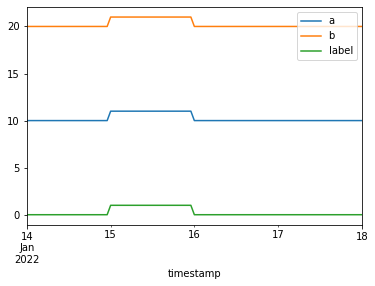

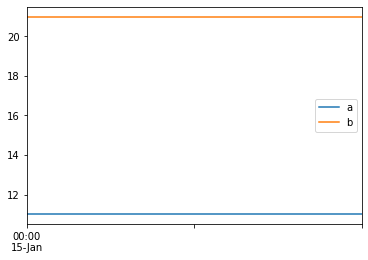

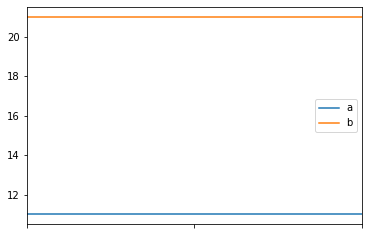

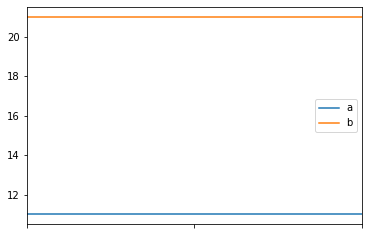

In [14]:
tst.run (test_window_generator, tag='dummy')

## WindowAggregator

This class produces the the inverse transform of the `WindowGenerator`class. In other words, when applied to the result of `WindowGenerator`, we obtain the original time-series. 

This class can be useful for aggregating the windowed data after it has been transformed by other components in the pipeline, so that we get back the same type of time-series we had at the beginning, but with all the transformations applied to it.

In [ ]:
#export
class WindowAggregator (SamplingComponent):
    """This class produces the the inverse transform of the WindowGeneratorclass. 
    
    In other words, when applied to the result of WindowGenerator, we obtain the 
    original time-series.
    
    This class can be useful for aggregating the windowed data after it has been 
    transformed by other components in the pipeline, so that we get back the same 
    type of time-series we had at the beginning, but with all the transformations 
    applied to it. For instance it can be used to unroll the error signal coming 
    out of the ResidualComputer. In principle, the aggregation can use different 
    statistics, although currently we only allow the mean operator, which obtains 
    the inverse transform."""
    def __init__ (self, sequence_length=None, sequence_stride=None, sampling_interval=None,
                  mixed_labels=False, **kwargs):
        """
        Initialize fields.
        
        Parameters
        ----------
        sequence_length : int, optional
            Size of each window, in number of timesteps.
        sequence_stride : int, optional
            Period between successive output sequences. 
            For stride s, output samples would start at index 
            data[i], data[i + s], data[i + 2 * s], etc.:
            https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array
        sampling_interval : int, optional
            Take one sample every `sampling_interval` minutes.
        mixed_labels : bool, optional
            Whether the same window can contain both anomaly and normal
            data (Default=False).
        """
        super().__init__ (**kwargs)
        self.sequence_length = sequence_length
        self.sequence_stride = sequence_stride
        self.sampling_interval = sampling_interval
        self.mixed_labels = mixed_labels

    def _fit (self, X, y=None):
        return self

    def _transform (self, X):
        df = self.aggregate (X)

        # select only those windows that are appropriate
        df = df[~df.isna().any(axis=1)]

        if not self.mixed_labels:
            all_normal = (df.label == 0)
            all_anomaly = (df.label == 1)
            df = df[all_normal | all_anomaly]
            label = df.pop('label')
            df['label'] = 0
            df.loc[all_anomaly, 'label'] = 1

        df.index.name = 'timestamp'
        df['label'] = df.label.astype(float)

        return df

    def aggregate(self, df):
        '''Reconstruct time-series from windows.

        The resulting time-series has a shape similar to the original one before the windowing was applied'''

        #sampling_interval = (df.index[0][1]-df.index[0][0])/(self.sequence_length-1)

        # fill gaps with NaN
        index = df.index.get_level_values(0)
        label = df['label']
        df = df.drop(columns='label')
        original_columns = df.columns.get_level_values(0).unique()
        #df = pd.DataFrame(np.arange(len(index)), index=index)
        
        # resample timestamps and labels
        df.index = index
        label.index = index
        df = df.resample(f'{self.sampling_interval}min').asfreq()
        index = df.index
        label = label.resample(f'{self.sampling_interval}min').fillna(method='ffill')
        
        last_window = pd.date_range(index[-1], periods=self.sequence_length, 
                                    freq=f'{self.sampling_interval}min')
        index = np.r_[index, last_window[1:]]
        label = np.r_[label.values[:], [label.values[-1]]*(self.sequence_length-1)]

        # generate windows of time indexes and labels
        ts = timeseries_dataset_from_array (np.arange(index.shape[0]), None, self.sequence_length,
                                                    sequence_stride=self.sequence_stride, batch_size=1)
        ls = timeseries_dataset_from_array (label, None, self.sequence_length,
                                                    sequence_stride=self.sequence_stride, batch_size=1)
        ts = ts.unbatch().as_numpy_iterator()
        ls = ls.unbatch().as_numpy_iterator()
        list_ts = list(ts)
        list_ls = list(ls)
        array_ts = np.array([x.tolist() for x in list_ts])
        array_ls = np.array([x.tolist() for x in list_ls])
        dft = pd.DataFrame (array_ts)
        dfl = pd.DataFrame (array_ls)

        times = dft.values.ravel()
        label = dfl.values.ravel()
        number_rows = times.shape[0]
        number_columns = len(original_columns) + 2
        df_ravel = pd.DataFrame (np.zeros((number_rows, number_columns)),
                                 columns=list(original_columns)+['label', 'times'])

        
        df_ravel['times'] = times
        df_ravel['label'] = label

        for c in original_columns:
            df_ravel[c] = df[c].values.ravel()

        df_aggregated = df_ravel.groupby('times').mean()

        df_aggregated.index = index[df_aggregated.index]

        return df_aggregated

### Example / test

In [ ]:
# exports tests.blocks.test_preprocessing
#@pytest.mark.reference_fails
def test_window_aggregator ():
    df = generate_input_for_window_generator ()
    window_generator = WindowGenerator(sequence_length=3, sequence_stride=1, sampling_interval=60)
    window_data = window_generator.transform(df)
    window_aggregator = WindowAggregator (sequence_length=3, sequence_stride=1, sampling_interval=60)
    df2 = window_aggregator.transform (window_data)
    assert (df==df2).all().all() and (df.index==df2.index).all()

In [ ]:
tst.run (test_window_aggregator, tag='dummy', debug=False)